In [1]:
colab = True

if colab:
  from google.colab import drive
  drive.mount('/content/drive/')




Mounted at /content/drive/


In [2]:
#%cd drive/MyDrive/Thesis/CL
#%cd drive/MyDrive/Thesis
%cd drive/MyDrive/EEE199/Thesis
%pwd

/content/drive/.shortcut-targets-by-id/1y9XYxPPSA_BuwrgEldj9-q_4xdMkiPui/Thesis


'/content/drive/.shortcut-targets-by-id/1y9XYxPPSA_BuwrgEldj9-q_4xdMkiPui/Thesis'

 <a id="1"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;color:#E1F16B;font-size:150%;text-align:center;border-radius:20px 60px;">IMPORTING LIBRARIES</p>

In [3]:
#Importing all the libraries to be used
import Lem #importing python file for Filipino lemmatization
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import pickle
import nltk

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap




In [4]:
if colab:
  nltk.download('punkt')
  nltk.download('stopwords')
  nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


<a id="2"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;color:#E1F16B;font-size:150%;text-align:center;border-radius:20px 60px;">LOADING DATA</p>

In [5]:

directory = '/content/drive/MyDrive/EEE199/Thesis/'
os.makedirs(directory, exist_ok=True)


In [6]:
#Loading data
data = pd.read_csv('dataset.csv', encoding='latin-1')
data.info()

filename = 'words.txt'

enlist = np.loadtxt(filename, delimiter= ' ', dtype = str, encoding='latin-1')

filename = 'tagalog_dict.txt'

fillist = np.loadtxt(filename, delimiter= ' ', dtype = str, encoding='latin-1')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6413 entries, 0 to 6412
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      6413 non-null   object
 1   v2      6413 non-null   object
dtypes: object(2)
memory usage: 100.3+ KB


In [7]:
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()




,Target,Text
0,ham,You have paid P50.00 of GCash to purchase GIGA...
1,ham,It's not too late to claim your FREEBIE of 350...
2,ham,Double up the power of your GigaPoints for cha...
3,ham,We're bringing G MUSIC FEST to you! Enjoy worl...
4,ham,Can you feel the love already? We're spending ...


**The dataset consists of 6,413 messages in English. The data is designated as being ham or spam.  Dataframe has two columns. The first column is "Target" indicating the class of message as ham or spam and the second "Text" column is the string of text.**

<a id="3"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;color:#E1F16B;font-size:150%;text-align:center;border-radius:20px 60px;">DATA EXPLORATION</p>

Text(0, 0.5, 'Number of Data points')

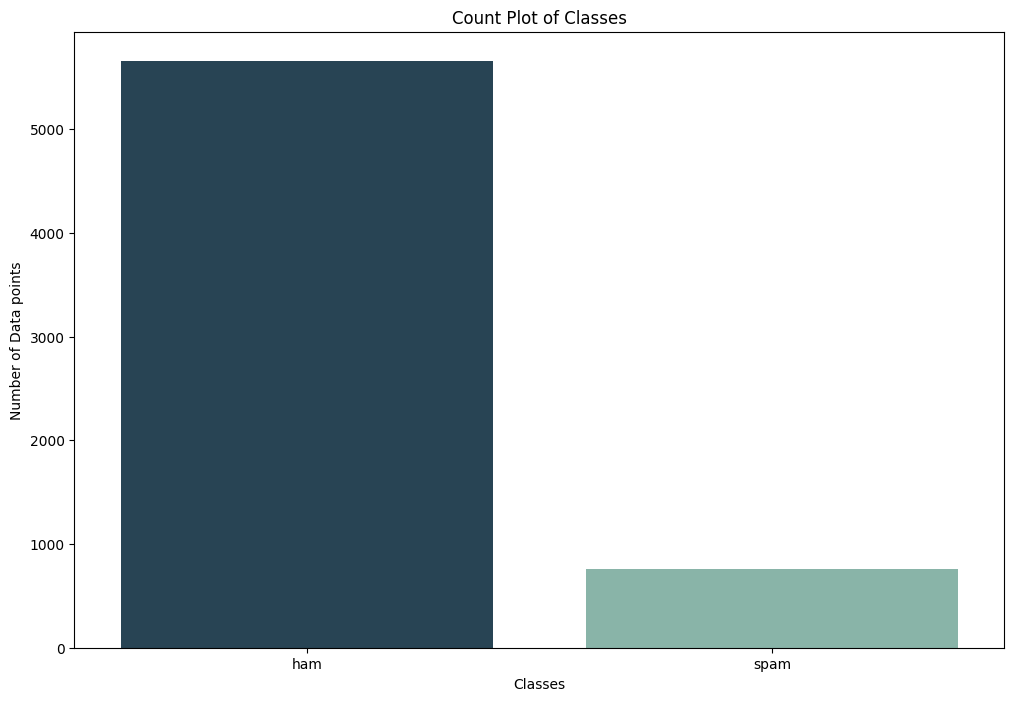

In [8]:
#Palette
cols= ["#21465B", "#82BBAB"]

#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Target"], palette= cols)
fg.set_title("Count Plot of Classes", color="#000000")
fg.set_xlabel("Classes", color="#000000")
fg.set_ylabel("Number of Data points", color="#000000")

**Note:** From the above countplot the data imbalance is quite evident.

<a id="3.1"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">FEATURE ENGINEERING</p>

For the purpose of data exploration, I am creating new features

* No_of_Characters: Number of characters in the text message
* No_of_Words: Number of words in the text message
* No_of_sentence: Number of sentences in the text message

In [9]:
#Adding a column of numbers of charachters,words and sentences in each msg
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

#PS. At this step, I tokenised the words and sentences and used the length of the same.
#More on Tokenizing later in the notebook.

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,6413.0,142.028692,106.832039,1.0,66.0,134.0,174.0,1235.0
No_of_Words,6413.0,28.736629,21.741736,1.0,14.0,26.0,37.0,251.0
No_of_sentence,6413.0,2.968969,1.801730,1.0,1.0,3.0,4.0,15.0


<Figure size 1200x800 with 0 Axes>

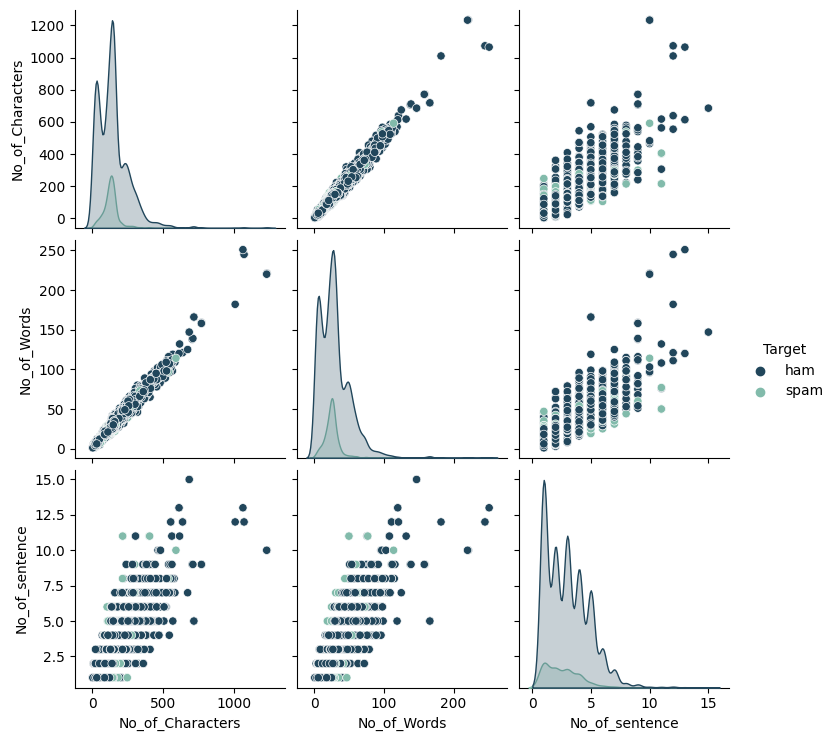

In [10]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

**Note:** From the pair plot, we can see a few outliers all in the class ham. This is interesting as we could put a cap over one of these. As they essentially indicate the same thing ie the length of SMS.

Next, I shall be dropping the outliers

<a id="3.2"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">OUTLIER DETECTION</p>

In [11]:
#Dropping the outliers.
data = data[(data["No_of_Characters"]<650)]
data.shape

(6388, 5)

<Figure size 1200x800 with 0 Axes>

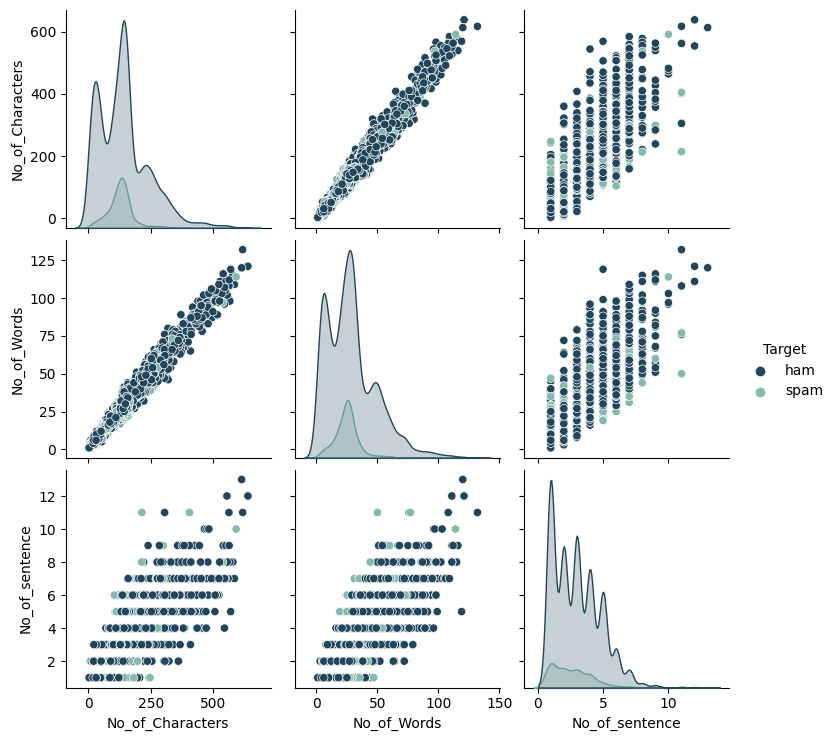

In [12]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

*Of course, I already knew it would just zoom into, but I still replotted it because look at all those pretty colours! (:*

<a id="4"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;color:#E1F16B;font-size:150%;text-align:center;border-radius:20px 60px;">DATA PREPREPROCESSING</p>

<a id="4.1"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">CLEANING TEXT</p>

The data cleaning process NLP is crucial. The computer doesn’t understand the text. for the computer, it is just a cluster of symbols. To further process the data we need to make the data cleaner.

* In the first step we extract only the alphabetic characters by this we are removing punctuation and numbers.
* In the next step, we are converting all the characters into lowercase.

This text will be then used in further procrssing

In [13]:
#Lets have a look at a sample of texts before cleaning
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*data["Text"][:5], sep = "\n")

 The First 5 Texts:
You have paid P50.00 of GCash to purchase GIGA VIDEO 50 for 09204987398 on 08-13-22 10:42 AM.
 Your GCash balance is P249.28. Ref. No. 369768899.
It's not too late to claim your FREEBIE of 350MB for surfing valid for 3 days. Simply load a total of P50 by 04/14/2022. #BestTimeWithGlobe Share-A-Load not included. If you've already claimed your freebie, please disregard this message. REF#: DGR65
Double up the power of your GigaPoints for chances to win MILLIONS in cash prizes WEEKLY! Join GIGA MANIA with a tap on the GigaLife App! smrt.ph/GigaLifeApp
We're bringing G MUSIC FEST to you! Enjoy world-class performances by Unique Salonga, The Juans, KAIA, and many more right at home on September 17. Join the festival virtually via KUMU at kumu.live/enjoyglobe and donate to Hapag Movement by sending virtual gifts during the stream. #ExtraGDayEveryday
Can you feel the love already? We're spending this season with absolutely ZERO convenience fee on bank transfers via InstaPay

In [14]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
you have paid p of gcash to purchase giga video for on am your gcash balance is p ref no
it s not too late to claim your freebie of mb for surfing valid for days simply load a total of p by besttimewithglobe share a load not included if you ve already claimed your freebie please disregard this message ref dgr
double up the power of your gigapoints for chances to win millions in cash prizes weekly join giga mania with a tap on the gigalife app smrt ph gigalifeapp
we re bringing g music fest to you enjoy world class performances by unique salonga the juans kaia and many more right at home on september join the festival virtually via kumu at kumu live enjoyglobe and donate to hapag movement by sending virtual gifts during the stream extragdayeveryday
can you feel the love already we re spending this season with absolutely zero convenience fee on bank transfers via instapay share the joy with your friends and loved ones until feb and transfer money to oth

<a id="4.2"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">TOKENIZATION</p>

**Tokenization** is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words.
I am splitting the Clean_Text into words at this step.

In [15]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['you', 'have', 'paid', 'p', 'of', 'gcash', 'to', 'purchase', 'giga', 'video', 'for', 'on', 'am', 'your', 'gcash', 'balance', 'is', 'p', 'ref', 'no']
['it', 's', 'not', 'too', 'late', 'to', 'claim', 'your', 'freebie', 'of', 'mb', 'for', 'surfing', 'valid', 'for', 'days', 'simply', 'load', 'a', 'total', 'of', 'p', 'by', 'besttimewithglobe', 'share', 'a', 'load', 'not', 'included', 'if', 'you', 've', 'already', 'claimed', 'your', 'freebie', 'please', 'disregard', 'this', 'message', 'ref', 'dgr']
['double', 'up', 'the', 'power', 'of', 'your', 'gigapoints', 'for', 'chances', 'to', 'win', 'millions', 'in', 'cash', 'prizes', 'weekly', 'join', 'giga', 'mania', 'with', 'a', 'tap', 'on', 'the', 'gigalife', 'app', 'smrt', 'ph', 'gigalifeapp']
['we', 're', 'bringing', 'g', 'music', 'fest', 'to', 'you', 'enjoy', 'world', 'class', 'performances', 'by', 'unique', 'salonga', 'the', 'juans', 'kaia', 'and', 'many', 'more', 'right', 'at', 'home', 'on', 'september', '

<a id="4.3"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">REMOVING STOPWORDS</p>

**Stopwords** are frequently occurring words(*such as few, is, an, etc*). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP. For the purpose of removing redundancy in our processing, I am removing those. NLTK library has a set of default stopwords that we will be removing.

In [16]:
# Removing the stopwords function
stop_words_en = set(stopwords.words("english"))
#print(stop_words_en)
stop_words_fil = set(line.strip() for line in open('filipino.txt'))
stop_words_en.update(stop_words_fil)
#print(stop_words_en)
def remove_stopwords(text):

    filtered_text = [word for word in text if word not in stop_words_en]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['paid', 'p', 'gcash', 'purchase', 'giga', 'video', 'gcash', 'balance', 'p', 'ref']
['late', 'claim', 'freebie', 'mb', 'surfing', 'valid', 'days', 'simply', 'load', 'total', 'p', 'besttimewithglobe', 'share', 'load', 'included', 'already', 'claimed', 'freebie', 'please', 'disregard', 'message', 'ref', 'dgr']
['double', 'power', 'gigapoints', 'chances', 'win', 'millions', 'cash', 'prizes', 'weekly', 'join', 'giga', 'mania', 'tap', 'gigalife', 'app', 'smrt', 'ph', 'gigalifeapp']
['bringing', 'g', 'music', 'fest', 'enjoy', 'world', 'class', 'performances', 'unique', 'salonga', 'juans', 'kaia', 'many', 'right', 'home', 'september', 'join', 'festival', 'virtually', 'via', 'kumu', 'kumu', 'live', 'enjoyglobe', 'donate', 'hapag', 'movement', 'sending', 'virtual', 'gifts', 'stream', 'extragdayeveryday']
['feel', 'love', 'already', 'spending', 'season', 'absolutely', 'zero', 'convenience', 'fee', 'bank', 'transfers', 'via', 'instapay', 'share', '

<a id="4.4"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">LEMMATIZATION</p>

**Stemming** is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word.

**lemmatization** also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English.

In [17]:
lemmatizer = WordNetLemmatizer()
#print(data["Nostopword_Text"])
# lemmatize string
def lemmatize_word(text):
    lemmas = []
    for word in text:
        if word in fillist:
            newword = Lem.stemmer(word)
        else:
            newword = lemmatizer.lemmatize(word, pos ='v')
        lemmas.append(newword)

    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['pay', 'p', 'gcash', 'purchase', 'giga', 'video', 'gcash', 'balance', 'p', 'ref']
['late', 'claim', 'freebie', 'mb', 'surf', 'valid', 'days', 'simply', 'load', 'total', 'p', 'besttimewithglobe', 'share', 'load', 'include', 'already', 'claim', 'freebie', 'please', 'disregard', 'message', 'ref', 'dgr']
['double', 'power', 'gigapoints', 'chance', 'win', 'millions', 'cash', 'prize', 'weekly', 'join', 'giga', 'mania', 'tap', 'gigalife', 'app', 'smrt', 'ph', 'gigalifeapp']
['bring', 'g', 'music', 'fest', 'enjoy', 'world', 'class', 'performances', 'unique', 'salonga', 'juans', 'kaia', 'many', 'right', 'home', 'september', 'join', 'festival', 'virtually', 'via', 'kumu', 'kumu', 'live', 'enjoyglobe', 'donate', 'hapag', 'movement', 'send', 'virtual', 'gift', 'stream', 'extragdayeveryday']
['feel', 'love', 'already', 'spend', 'season', 'absolutely', 'zero', 'convenience', 'fee', 'bank', 'transfer', 'via', 'instapay', 'share', 'joy', 'friends', 'love', 'ones

<a id="5"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;font-size:150%;color:#E1F16B;text-align:center;border-radius:20px 60px;">VECTORIZE</p>

**TF-IDF** in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents)
Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t))
I will be using TfidfVectorizer() to vectorize the preprocessed data.

**Steps in the Vectorizing:**
* Creating a corpus of lemmatized text
* Converting the corpus in vector form
* Label Encoding the classes in Target

*Note: So far we have been stalking up columns in our data for the purpose of explanation*

In [18]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
pay p gcash purchase giga video gcash balance p ref
late claim freebie mb surf valid days simply load total p besttimewithglobe share load include already claim freebie please disregard message ref dgr
double power gigapoints chance win millions cash prize weekly join giga mania tap gigalife app smrt ph gigalifeapp
bring g music fest enjoy world class performances unique salonga juans kaia many right home september join festival virtually via kumu kumu live enjoyglobe donate hapag movement send virtual gift stream extragdayeveryday
feel love already spend season absolutely zero convenience fee bank transfer via instapay share joy friends love ones feb transfer money bank freeinfomsg


In [19]:
#Changing text data in to numbers.
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature
X.dtype

dtype('float64')

In [20]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

0       0
1       0
2       0
3       0
4       0
       ..
6408    0
6409    0
6410    0
6411    0
6412    0
Name: Target, Length: 6388, dtype: int64


<a id="6"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;font-size:150%;color:#E1F16B;text-align:center;border-radius:20px 60px;">TRAIN-TEST AND CLIENT SPLIT</p>

**Steps involved in the Model Building**
* Setting up features and target as X and y
* Splitting the testing and training sets
* Split into 3 clients

In [24]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = data["Target"]
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train.to_csv(directory + 'train_labels.csv')
y_test.to_csv(directory + 'test_labels.csv')
np.save(directory + 'train_data', X_train)
np.save(directory + 'test_data', X_test)

In [22]:
# Split train to 3 clients while maintaining ham-spam percentages

# Create or load your NumPy database and label array
train_database = X_train  # Your NumPy array
train_labels = y_train  # Labels corresponding to the database
save1 = pd.Series([])
save2 = pd.Series([])
save3 = pd.Series([])

# Determine the number of elements in the database and calculate the chunk size for each client
total_elements = len(train_database)
chunk_size = total_elements // 3
remainder = total_elements % 3  # Calculate the remainder

# Calculate the number of elements each client should receive, adjusting for remainders
client1_size = chunk_size + remainder
client2_size = chunk_size
client3_size = chunk_size

# Initialize empty arrays to hold the split data for each client
client1_train_data = np.empty((0, train_database.shape[1]))  # Assuming the database has 2 dimensions
client2_train_data = np.empty((0, train_database.shape[1]))
client3_train_data = np.empty((0, train_database.shape[1]))
client1_train_labels = np.empty((0,), dtype=train_labels.dtype)
client2_train_labels = np.empty((0,), dtype=train_labels.dtype)
client3_train_labels = np.empty((0,), dtype=train_labels.dtype)

# Get unique labels and their counts

unique_labels, label_counts = np.unique(train_labels, return_counts=True)

for label in unique_labels:
    label_data = train_database[train_labels == label]
    label_set = train_labels[train_labels == label]
    label_count = label_counts[label]
    ha = np.where(train_database[train_labels == label])
    chunk_size = label_count// 3
    remainder = label_count % 3

    # Determine the number of elements for each client, adjusting for remainders and label counts
    client1_label_count = chunk_size + remainder
    client2_label_count = chunk_size
    client3_label_count = chunk_size

    # Split the label data into equal parts for each client, considering the adjusted sizes
    start_idx = 0
    client1_train_data = np.vstack((client1_train_data, label_data[start_idx : start_idx + client1_label_count]))
    client1_train_labels = pd.concat([save1,label_set[start_idx : start_idx + client1_label_count]])
    save1 = client1_train_labels
    start_idx += client1_label_count
    client2_train_data = np.vstack((client2_train_data, label_data[start_idx : start_idx + client2_label_count]))
    client2_train_labels = pd.concat([save2,label_set[start_idx : start_idx + client2_label_count]])
    save2 = client2_train_labels
    start_idx += client2_label_count
    client3_train_data = np.vstack((client3_train_data, label_data[start_idx : start_idx + client3_label_count]))
    client3_train_labels = pd.concat([save3,label_set[start_idx : start_idx + client3_label_count]])
    save3 = client3_train_labels
    save1.to_csv(directory + 'client1_train_labels_new.csv')

# Now, client1_data, client2_data, and client3_data contain approximately equal parts of the original database,
# assigned to each respective client, while maintaining the original class distribution.
# The corresponding labels are stored in client1_labels, client2_labels, and client3_labels.

#np.save(directory + 'client1_train_labels_new.npy', client1_train_labels)
np.save(directory + 'client1_train_inputs_new.npy', client1_train_data)
#np.save(directory + 'client2_train_labels_new.npy', client2_train_labels)
np.save(directory + 'client2_train_inputs_new.npy', client2_train_data)
#np.save(directory + 'client3_train_labels_new.npy', client3_train_labels)
np.save(directory + 'client3_train_inputs_new.npy', client3_train_data)
save1.to_csv(directory + 'client1_train_labels_new.csv')
save2.to_csv(directory + 'client2_train_labels_new.csv')
save3.to_csv(directory + 'client3_train_labels_new.csv')

<ipython-input-22-04c6e3943c9e>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  save1 = pd.Series([])
<ipython-input-22-04c6e3943c9e>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  save2 = pd.Series([])
<ipython-input-22-04c6e3943c9e>:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  save3 = pd.Series([])


In [23]:
# Split evaluation to 3 clients while maintaining ham-spam percentages

# Create or load your NumPy database and label array
test_database = X_test  # Your NumPy array
test_labels = y_test  # Labels corresponding to the database
save1 = pd.Series([])
save2 = pd.Series([])
save3 = pd.Series([])

# Determine the number of elements in the database and calculate the chunk size for each client
total_elements = len(test_database)
chunk_size = total_elements // 3
remainder = total_elements % 3  # Calculate the remainder

# Calculate the number of elements each client should receive, adjusting for remainders
client1_size = chunk_size + remainder
client2_size = chunk_size
client3_size = chunk_size

# Initialize empty arrays to hold the split data for each client
client1_test_data = np.empty((0, test_database.shape[1]))  # Assuming the database has 2 dimensions
client2_test_data = np.empty((0, test_database.shape[1]))
client3_test_data = np.empty((0, test_database.shape[1]))
client1_test_labels = np.empty((0,), dtype=test_labels.dtype)
client2_test_labels = np.empty((0,), dtype=test_labels.dtype)
client3_test_labels = np.empty((0,), dtype=test_labels.dtype)

# Get unique labels and their counts

unique_labels, label_counts = np.unique(test_labels, return_counts=True)

for label in unique_labels:
    label_data = test_database[test_labels == label]
    label_count = label_counts[label]
    label_set = test_labels[test_labels == label]

    chunk_size = label_count// 3
    remainder = label_count % 3

    # Determine the number of elements for each client, adjusting for remainders and label counts
    client1_label_count = chunk_size + remainder
    client2_label_count = chunk_size
    client3_label_count = chunk_size
    start_idx = 0
    client1_test_data = np.vstack((client1_test_data, label_data[start_idx : start_idx + client1_label_count]))
    #client1_test_labels = np.concatenate((client1_test_labels, test_labels[start_idx : start_idx + client1_label_count]))
    client1_test_labels = pd.concat([save1,label_set[start_idx : start_idx + client1_label_count]])
    save1 = client1_test_labels
    start_idx += client1_label_count
    client2_test_data = np.vstack((client2_test_data, label_data[start_idx : start_idx + client2_label_count]))
    #client2_test_labels = np.concatenate((client2_test_labels, test_labels[start_idx : start_idx + client2_label_count]))
    client2_test_labels = pd.concat([save2,label_set[start_idx : start_idx + client2_label_count]])
    save2 = client2_test_labels
    start_idx += client2_label_count
    client3_test_data = np.vstack((client3_test_data, label_data[start_idx : start_idx + client3_label_count]))
    #client3_test_labels = np.concatenate((client3_test_labels, test_labels[start_idx : start_idx + client3_label_count]))
    client3_test_labels = pd.concat([save3,label_set[start_idx : start_idx + client3_label_count]])
    save3 = client3_test_labels


#np.save(directory + 'client1_test_labels_new.npy', client1_test_labels)
np.save(directory + 'client1_test_inputs_new.npy', client1_test_data)
#np.save(directory + 'client2_test_labels_new.npy', client2_test_labels)
np.save(directory + 'client2_test_inputs_new.npy', client2_test_data)
#np.save(directory + 'client3_test_labels_new.npy', client3_test_labels)
np.save(directory + 'client3_test_inputs_new.npy', client3_test_data)
save1.to_csv(directory + 'client1_test_labels_new.csv')
save2.to_csv(directory + 'client2_test_labels_new.csv')
save3.to_csv(directory + 'client3_test_labels_new.csv')

<ipython-input-23-66e3d69dfcd8>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  save1 = pd.Series([])
<ipython-input-23-66e3d69dfcd8>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  save2 = pd.Series([])
<ipython-input-23-66e3d69dfcd8>:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  save3 = pd.Series([])
